# 自然言語から画像を検索するプログラム

In [51]:
import os
import torch
# import clip
import japanese_clip as ja_clip
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms


## モデルの定義

In [52]:
# デバイスの設定（GPUまたはCPU）
device = "cuda" if torch.cuda.is_available() else "cpu"

# Japanese CLIPモデルと前処理関数の読み込み
model, _ = ja_clip.load('rinna/japanese-clip-vit-b-16', device=device)

## 画像の前処理クラスの定義

In [53]:
mean = [0.48145466, 0.4578275, 0.40821073]
std = [0.26862954, 0.26130258, 0.27577711]

## 画像の前処理クラス
class LetterboxTransform:
    def __init__(self, size=(224,224), fill_color=(0,0,0)):
        self.size = size
        self.fill_color = fill_color

    def __call__(self, img: Image.Image):
        w, h = img.size
        scale = min(self.size[0]/h, self.size[1]/w)
        new_w = int(w * scale)
        new_h = int(h * scale)

        # リサイズ（アスペクト比保持）
        resized = img.resize((new_w, new_h), Image.BILINEAR)

        # 新しい224x224の黒背景キャンバスを作る
        new_img = Image.new("RGB", self.size, self.fill_color)
        top = (self.size[1] - new_h)//2
        left = (self.size[0] - new_w)//2
        new_img.paste(resized, (left, top))
        return new_img

# 新たな前処理パイプラインを定義
# 1. アスペクト比維持でLetterboxで224x224へ
# 2. ToTensor()でTensor化
# 3. CLIP標準化(mean/std)
preprocess = transforms.Compose([
    LetterboxTransform(size=(224,224), fill_color=(0,0,0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## 撮影画像をベクトル化する処理

In [54]:
# 画像フォルダのパスを指定
image_folder = "/Users/nakashimaryotaro/Desktop/自己学習/AI画像検索_簡易版/myfolder"

# 画像ファイルのパスを取得
image_paths = [
    os.path.join(image_folder, fname)
    for fname in os.listdir(image_folder)
    if fname.endswith(('.jpg', '.JPG', '.jpeg', '.png', '.PNG'))
]

# 画像のベクトル表現とファイルパスを格納するリスト
image_embeddings = []
image_files = []

# 各画像をベクトル化
for image_path in tqdm(image_paths, desc="画像の処理中"):
    try:
        # 画像を開き、前処理を適用
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            # 画像をベクトル表現にエンコード
            image_embedding = model.get_image_features(image)
        # ベクトルを正規化
        image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
        # 次元を統一してリストに追加
        image_embeddings.append(image_embedding.cpu().numpy().squeeze(0))
        image_files.append(image_path)
    except Exception as e:
        print(f"{image_path} の処理中にエラー: {e}")

# ベクトルを結合
if len(image_embeddings) == 0:
    raise ValueError("image_embeddingsが空です。画像フォルダのパスを確認してください。")
image_embeddings = np.stack(image_embeddings, axis=0)


画像の処理中: 100%|██████████| 287/287 [04:07<00:00,  1.16it/s]


## クエリ（検索文字列）をベクトル化し、ベクトル化した画像から類似したものを探す関数の定義

In [55]:
# PyTorchのTensorに変換
embedding_dim = 512  # 埋め込み次元（モデルに依存）
image_embeddings = torch.tensor(image_embeddings, device=device).view(-1, embedding_dim)

# 検索関数
def search(query, image_embeddings, image_files, top_k=5):
    with torch.no_grad():
        # クエリをベクトル化
        tokens = ja_clip.tokenize(query)
        input_ids = tokens['input_ids'].to(device)
        attention_mask = tokens['attention_mask'].to(device)

        # テキストをベクトル化
        text_embedding = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

        # 検索スコア計算
        scores = torch.matmul(text_embedding, image_embeddings.T)

        # スコア上位を取得
        top_scores, indices = torch.topk(scores, top_k)

        # indicesとtop_scoresは[1, top_k]の形状になっているので0行目を参照
        indices = indices[0]       # (top_k,) 形状
        top_scores = top_scores[0] # (top_k,) 形状

        # enumerateを使って各順位j（0～top_k-1）とインデックスidxを取得
        results = []
        for j, idx in enumerate(indices):
            img_idx = idx.item()
            score = top_scores[j].item()
            results.append((image_files[img_idx], score))

        return results


## 検索の実行・画像の可視化

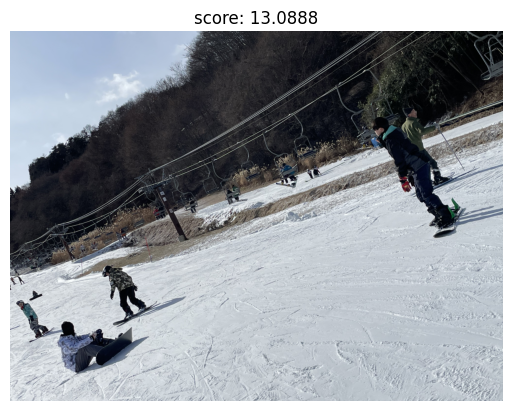

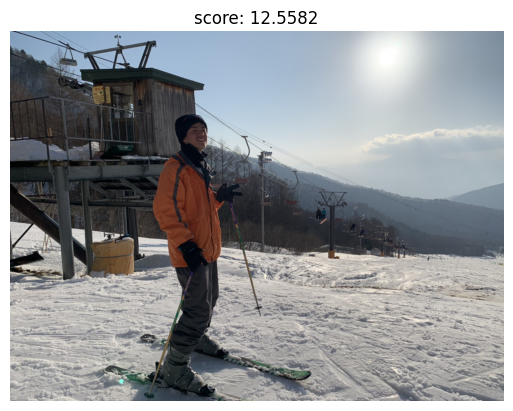

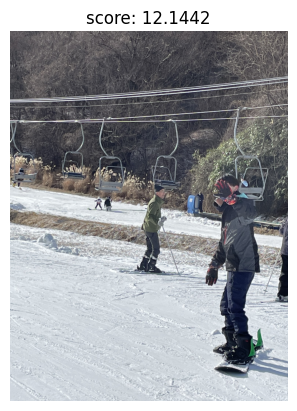

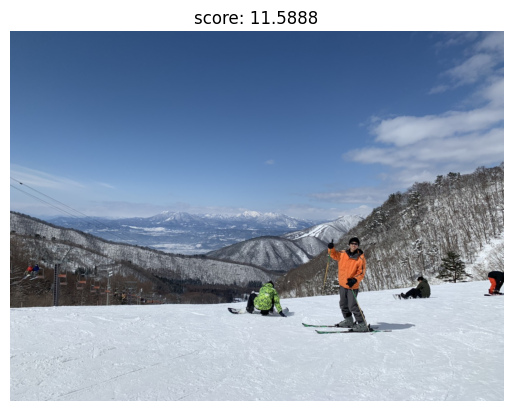

In [64]:
# 検索クエリ
# query = "ガラスに囲われている神社"
# query = "寺"
# query = "つけ麺。皿が２つある"
query = "スキー場で、ピースしてる男"

# 検索実行
results = search(query, image_embeddings, image_files, top_k=4)

# 検索結果を表示
for img_path, score in results:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"score: {score:.4f}")
    plt.axis('off')
    plt.show()

## モデルの注目箇所を可視化する処理

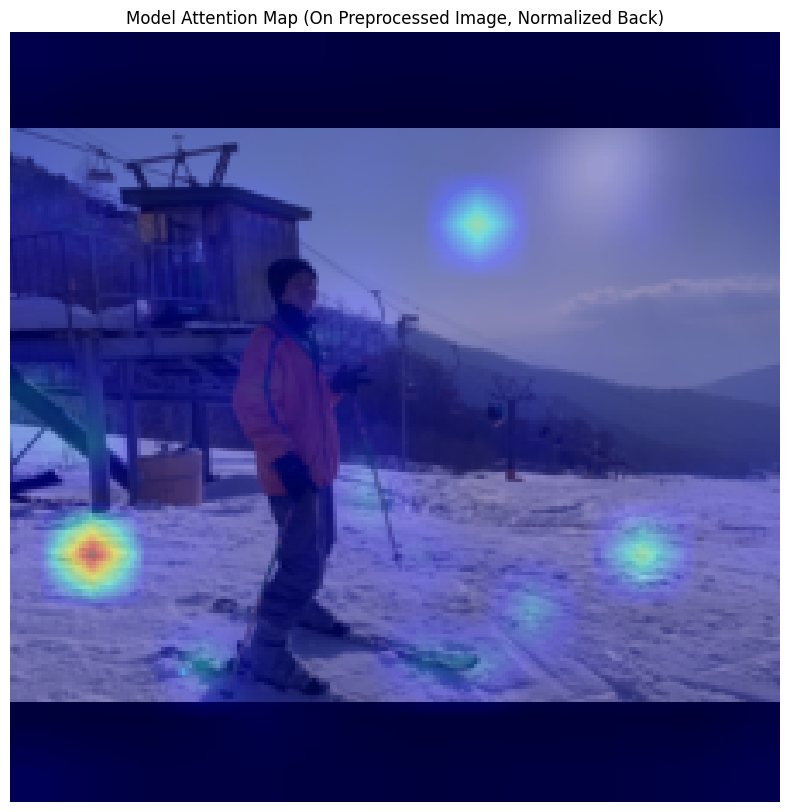

In [57]:
# アテンション可視化のための画像選択（上位1件を例に）
img_path = results[1][0]
image = Image.open(img_path)
image_input = preprocess(image).unsqueeze(0).to(device)

# アテンション取得
model.vision_model.config.output_attentions = True
with torch.no_grad():
    outputs = model.vision_model(image_input, output_attentions=True)

attentions = outputs.attentions
last_layer_attention = attentions[-1]
avg_attention = last_layer_attention.mean(dim=1)  # [batch, tokens, tokens]

# CLSトークンから他トークンへのAttention
cls_attention = avg_attention[0, 0, 1:]
num_patches = cls_attention.shape[0]
patch_size = int(num_patches**0.5)
cls_attention = cls_attention.reshape(patch_size, patch_size).cpu().numpy()

# Attention正規化
cls_attention = cls_attention - cls_attention.min()
cls_attention = cls_attention / cls_attention.max()

# preprocessで行われている正規化を逆変換
# 参考: CLIP標準化パラメータ（モデルにより異なるため適宜変更）
mean = [0.48145466, 0.4578275, 0.40821073]
std = [0.26862954, 0.26130258, 0.27577711]

# preprocess後の画像をnumpy化
input_image_np = image_input.squeeze(0).permute(1, 2, 0).cpu().numpy()

# 標準化解除
inv_image = input_image_np
for c in range(3):
    inv_image[..., c] = inv_image[..., c] * std[c] + mean[c]
inv_image = np.clip(inv_image, 0, 1)
inv_image_uint8 = (inv_image * 255).astype(np.uint8)

# Attentionマップを224x224に拡大
attention_resized = Image.fromarray((cls_attention*255).astype(np.uint8)).resize((224, 224), Image.BILINEAR)
attention_resized = np.array(attention_resized)

# 可視化
plt.figure(figsize=(10,10))
plt.imshow(inv_image_uint8)
plt.imshow(attention_resized, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Model Attention Map (On Preprocessed Image, Normalized Back)")
plt.show()

In [1]:
!pip list

Package                 Version
----------------------- -----------
anaconda-anon-usage     0.4.4
annotated-types         0.7.0
anyio                   4.6.2.post1
appnope                 0.1.4
archspec                0.2.3
asttokens               2.4.1
boltons                 23.0.0
Brotli                  1.0.9
certifi                 2024.7.4
cffi                    1.16.0
charset-normalizer      2.0.4
clip                    1.0
cloudpickle             3.1.0
comm                    0.2.2
conda                   24.7.1
conda-content-trust     0.2.0
conda-libmamba-solver   24.1.0
conda-package-handling  2.3.0
conda_package_streaming 0.10.0
contourpy               1.3.1
cryptography            42.0.5
cycler                  0.12.1
debugpy                 1.6.7
decorator               5.1.1
distro                  1.9.0
exceptiongroup          1.2.2
executing               2.0.1
Farama-Notifications    0.0.4
filelock                3.13.1
fonttools               4.55.0
frozendict      